### Import the required libraries and scripts

In [11]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
from tqdm.notebook import tqdm_notebook # Displays progress bars when querying data from BQ
import pandas as pd
import numpy as np
import scipy.stats
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from run_data_queries import run_data_queries_func # Import the function that runs the SQL script, which pulls the data of tests in 2022
import dill # Saves a Notebook session so that you don't have to re-run the script every time you open it. To restore a notebook session --> dill.load_session('mab_significance_analysis_notebook.db')
# Another way is to do it is to run %store -r {variables_to_load_separated_by_spaces_without_the_curly_brackers}. This is the recommended method. The steps are explained in instructions.txt

client = bigquery.Client(project = 'logistics-data-staging-flat') # Instantiate a BQ client
bq_storage_client = bigquery_storage.BigQueryReadClient() # Speeds us querying from BQ 

g:\My Drive\APAC\Autopricing\Bayesian Statistics and MAB\mab_significance_analysis\venv_mab_significance_analysis\lib\site-packages\google\auth\_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


### Define some inputs that will be further used in the analysis

In [12]:
opp_dir_deltas_threshold = 0.33 # The threshold beyond which we would consider contradictions between the deltas on the TS and experiment level too excessive 
alpha_threshold = 0.1 # This corresponds to a confidence level of 90%
lower_bound_ts_order_pct = 0.2 # The level below which we consider the experiment to have a low share of treatment orders (inclusive)
upper_bound_ts_order_pct = 0.5 # The level above which we consider the experiment to have a high share of treatment orders (exclusive). 
# In between 0.2 and 0.5 --> (0.2, 0.5] --> is 'Mid'

### Not all tests in 2022 were chosen. The tests that made the cut satisfied the following conditions:
* NOT misconfigured
* NOT active at the time of pulling the data
* NO customer or new customer conditions in any of the variants
* Experiment's length >= 6 days
* The treatment scope must have had > 0.5% of the total orders or sessions
* The number of treatment orders had to be > 0 AND not NULL
    * The number of treatment orders had to be larger than the # of treatment sessions
* The number of treatment sessions had to be > 0 AND not NULL
    * The number of experiment orders had to be larger than the # of treatment sessions

In [13]:
# Run the BQ script that pulls the data of tests in 2022 (takes about ~ 20 minutes)
run_data_queries_func("G:/My Drive/APAC/Autopricing/Bayesian Statistics and MAB/mab_significance_analysis/data_queries_v5_with_sub_vert_filter.sql")

The BQ script was executed successfully at 2022-07-05 15:25:01.660999


### Preview the final dataframe that will be used to calculate the significance on the **treatment** and **experiment** levels

In [14]:
sql_query_mab_dataset = """SELECT * FROM `dh-logistics-product-ops.pricing.kpis_per_user_mab_sig_analysis`"""

# The two following commands take ~ 8 minutes to complete under normal circumstances
sort_cols_1 = ['entity_id', 'country_code', 'test_id', 'perseus_client_id', 'variant', 'target_group']
df_raw_data_exp = client.query(sql_query_mab_dataset).result().to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook').sort_values(by = sort_cols_1)

# Convert the data types of the columns because they are not imported properly
df_raw_data_exp = df_raw_data_exp.astype({
    'entity_id': str, 'country_code': str, 'test_id': int, 'test_name': str, 'test_start_date': str, 'test_end_date': str, 'test_length': int, 
    'perseus_client_id': str, 'variant': str, 'target_group': str, 'session_in_treatment_flag': str, 
    'order_count_per_user': int, 'revenue_per_user': float, 'profit_per_user': float
})

df_raw_data_ts = df_raw_data_exp[df_raw_data_exp['session_in_treatment_flag'] == 'Y'] # Treatment scope only

# Preview the dataframes
print('The dataframe "df_raw_data_exp" contains {} rows, whereas the dataframe "df_raw_data_ts" contains {} rows'.format(len(df_raw_data_exp), len(df_raw_data_ts)))
df_raw_data_exp

Downloading:   0%|          | 0/6004938 [00:00<?, ?rows/s]

The dataframe "df_raw_data_exp" contains 6004938 rows, whereas the dataframe "df_raw_data_ts" contains 4639947 rows


,entity_id,country_code,test_id,test_name,test_start_date,test_end_date,test_length,first_parent_vertical,second_parent_vertical,perseus_client_id,variant,target_group,session_in_treatment_flag,order_count_per_user,revenue_per_user,profit_per_user,data_pull_timestamp
81285,FP_BD,bd,1,Dmart Experiment (5 variations),2022-03-15 13:41:27.545832+00:00,2022-05-05 06:17:16.280583+00:00,50,shop,None,1571930758344.53915142323362470.oc3eq649fwf,Variation1,TG1,Y,0,0.00,0.00,2022-07-05 13:24:15.666154+00:00
81286,FP_BD,bd,1,Dmart Experiment (5 variations),2022-03-15 13:41:27.545832+00:00,2022-05-05 06:17:16.280583+00:00,50,shop,None,1572273488438.575975939965303500.x0dyf0uy0y,Variation6,TG1,Y,3,79.89,-26.10,2022-07-05 13:24:15.666154+00:00
98757,FP_BD,bd,1,Dmart Experiment (5 variations),2022-03-15 13:41:27.545832+00:00,2022-05-05 06:17:16.280583+00:00,50,shop,None,1574138288079.739813137925740500.qcasxhkmwko,Variation5,TG1,Y,0,0.00,0.00,2022-07-05 13:24:15.666154+00:00
87485,FP_BD,bd,1,Dmart Experiment (5 variations),2022-03-15 13:41:27.545832+00:00,2022-05-05 06:17:16.280583+00:00,50,shop,None,1574771315632.892053852927034400.ypmlhxkb79,Variation2,TG1,Y,4,88.00,-35.38,2022-07-05 13:24:15.666154+00:00
81287,FP_BD,bd,1,Dmart Experiment (5 variations),2022-03-15 13:41:27.545832+00:00,2022-05-05 06:17:16.280583+00:00,50,shop,None,1575698737720.940941225721585172.fSgh7YmqID,Variation2,TG1,Y,4,88.00,-34.59,2022-07-05 13:24:15.666154+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489644,TB_QA,qa,21,(Slow Period) QA_20220525_R_B0_O_Price_Sensiti...,2022-06-19 11:23:03.310017+00:00,2022-06-29 12:47:59.774660+00:00,10,restaurant,None,1656501881131.7138902654.xtncyjlwor,Variation1,TG2,Y,1,20.07,8.57,2022-07-05 13:24:15.666154+00:00
466908,TB_QA,qa,21,(Slow Period) QA_20220525_R_B0_O_Price_Sensiti...,2022-06-19 11:23:03.310017+00:00,2022-06-29 12:47:59.774660+00:00,10,restaurant,None,1656502372976.6013795284.jvpcbqadgf,Control,TG1,Y,0,0.00,0.00,2022-07-05 13:24:15.666154+00:00
466909,TB_QA,qa,21,(Slow Period) QA_20220525_R_B0_O_Price_Sensiti...,2022-06-19 11:23:03.310017+00:00,2022-06-29 12:47:59.774660+00:00,10,restaurant,None,1656502372976.6013795284.jvpcbqadgf,Control,TG2,Y,0,0.00,0.00,2022-07-05 13:24:15.666154+00:00
395244,TB_QA,qa,21,(Slow Period) QA_20220525_R_B0_O_Price_Sensiti...,2022-06-19 11:23:03.310017+00:00,2022-06-29 12:47:59.774660+00:00,10,restaurant,None,1656502518154.6382710549.ztjxokwrhe,Variation2,TG2,Y,0,0.00,0.00,2022-07-05 13:24:15.666154+00:00


### Join the percentage of treatment orders to the dataset generated in the above step so that we can filter out tests with a low percentage of treatment orders

In [15]:
sql_query_ts_orders = """
    SELECT
        entity_id,
        country_code,
        test_id,
        ROUND(COUNT(DISTINCT CASE WHEN target_group != 'Non_TG' THEN order_id ELSE NULL END) / COUNT(DISTINCT order_id), 4) AS perc_treatment_orders    
    FROM `dh-logistics-product-ops.pricing.ab_test_individual_orders_cleaned_mab_sig_analysis`
    GROUP BY 1,2,3
    HAVING ROUND(COUNT(DISTINCT CASE WHEN target_group != 'Non_TG' THEN order_id ELSE NULL END) / COUNT(DISTINCT order_id), 4) > 0.01;
"""

df_ts_orders_pct = client.query(sql_query_ts_orders).result().to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

# Filter out tests that have a perc_treatment_orders < 1%
df_raw_data_exp = df_raw_data_exp.merge(df_ts_orders_pct, how = 'inner', on = ['entity_id', 'country_code', 'test_id'])
df_raw_data_ts = df_raw_data_ts.merge(df_ts_orders_pct, how = 'inner', on = ['entity_id', 'country_code', 'test_id'])

Downloading:   0%|          | 0/115 [00:00<?, ?rows/s]

### Calculate the p-values and deltas of all tests

In [16]:
# Create a list that contains the sorting columns
sort_cols_2 = ['entity_id', 'country_code', 'test_id', 'test_name', 'test_start_date', 'test_end_date', 'test_length', 'first_parent_vertical', 'second_parent_vertical', 'variant']
	
# Define a function the calculates the p-values of tests on the treatment and experiment levels
def calc_sig(df_func, analysis_level):
    # Create the strucutre of the data frame that will contain the significance values
    # The command below creates a data frame with the distinct combinations of "sort_cols_2" and appends two columns with NAs. These columns will be filled with p-values using the for loop below
    df_sig = df_func[sort_cols_2].drop_duplicates().sort_values(by = sort_cols_2).reset_index(drop = True)
    df_sig = df_sig.assign(
        # _per_user_conv_only takes into account converted users ONLY. _per_user takes into account both converted and unconverted users
        # The "delta" and "p_val" are both computed from converted and unconverted users
        avg_order_count_per_user_conv_only = None, avg_order_count_per_user = None, avg_order_count_per_user_delta = None, order_count_per_user_p_val = None, 
        avg_profit_per_user_conv_only = None, avg_profit_per_user = None, avg_profit_per_user_delta = None, profit_per_user_p_val = None
    ).reset_index(drop = True)

    # Calculate the p-values using the Mann-Whitney U test
    for idx in range(len(df_sig)):
        entity_iter = df_sig['entity_id'][idx] # Which variant will be used in this iteration?
        test_iter = df_sig['test_id'][idx] # Which variant will be used in this iteration?
        var_iter = df_sig['variant'][idx] # Which variant will be used in this iteration?
        
        df_stg = df_func[(df_func['entity_id'] == entity_iter) & (df_func['test_id'] == test_iter)]
        for col in ['order_count_per_user', 'profit_per_user']:
            var_col_conv_and_unconv = df_stg[col].loc[df_stg['variant'] == var_iter].to_numpy()
            var_col_conv_only = df_stg[col].loc[(df_stg['variant'] == var_iter) & (df_stg['revenue_per_user'] > 0)].to_numpy()
            control_col_conv_and_unconv = df_stg[col].loc[df_stg['variant'] == 'Control'].to_numpy()
            control_col_conv_only = df_stg[col].loc[(df_stg['variant'] == 'Control') & (df_stg['revenue_per_user'] > 0)].to_numpy()
            
            # If the row that is being iterated over belongs to a "Control" group entry, then only calculate the "means" without deltas or p-values
            if df_sig['variant'][idx] == "Control":
                df_sig.iloc[idx, df_sig.columns.get_loc('avg_' + col + '_conv_only')] = round(control_col_conv_only.mean(), 4)
                df_sig.iloc[idx, df_sig.columns.get_loc('avg_' + col)] = round(control_col_conv_and_unconv.mean(), 4)
            # If the row that is being iterated over belongs to a "non-Control" group entry, then calculate the deltas and p-values in addition to the means
            else:
                # Means
                df_sig.iloc[idx, df_sig.columns.get_loc('avg_' + col + '_conv_only')] = round(var_col_conv_only.mean(), 4)
                df_sig.iloc[idx, df_sig.columns.get_loc('avg_' + col)] = round(var_col_conv_and_unconv.mean(), 4)
                # Delta
                df_sig.iloc[idx, df_sig.columns.get_loc('avg_' + col + '_delta')] = round((var_col_conv_and_unconv.mean() - control_col_conv_and_unconv.mean()) / abs(control_col_conv_and_unconv.mean()), 4)
                # P-value
                df_sig.iloc[idx, df_sig.columns.get_loc(col + '_p_val')] = round(scipy.stats.mannwhitneyu(var_col_conv_and_unconv, control_col_conv_and_unconv, alternative = 'two-sided', nan_policy = 'omit')[1], 4)

    # Create a column that indicates whether the computation was done on the experiment or treatment scope level
    if analysis_level == 'exp':
        df_sig = df_sig.assign(granularity = 'exp') # Experiment level
    elif analysis_level == 'ts':
        df_sig = df_sig.assign(granularity = 'ts') # Treatment scope level

    return df_sig

df_sig_exp = calc_sig(df_func = df_raw_data_exp, analysis_level = 'exp')
df_sig_ts = calc_sig(df_func = df_raw_data_ts, analysis_level = 'ts')
df_sig_combined = pd.concat([df_sig_exp, df_sig_ts]) # Bind the two dataframes together by rows

# Add statistical significance flags to "df_sig_combined"
df_sig_combined['order_count_per_user_sig_flag'] = np.where(df_sig_combined['order_count_per_user_p_val'] <= alpha_threshold, 'Sig', 'Not Sig')
df_sig_combined['profit_per_user_sig_flag'] = np.where(df_sig_combined['profit_per_user_p_val'] <= alpha_threshold, 'Sig', 'Not Sig')

# Join "df_ts_orders_pct" containing the percentage of treatment orders on "df_sig_combined"
df_sig_combined = df_sig_combined.merge(df_ts_orders_pct, how = 'inner', on = ['entity_id', 'country_code', 'test_id'])
df_sig_combined

C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_1536\276315303.py:36: RuntimeWarning: Mean of empty slice.
  df_sig.iloc[idx, df_sig.columns.get_loc('avg_' + col + '_conv_only')] = round(var_col_conv_only.mean(), 4)
g:\My Drive\APAC\Autopricing\Bayesian Statistics and MAB\mab_significance_analysis\venv_mab_significance_analysis\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_1536\276315303.py:36: RuntimeWarning: Mean of empty slice.
  df_sig.iloc[idx, df_sig.columns.get_loc('avg_' + col + '_conv_only')] = round(var_col_conv_only.mean(), 4)
g:\My Drive\APAC\Autopricing\Bayesian Statistics and MAB\mab_significance_analysis\venv_mab_significance_analysis\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,entity_id,country_code,test_id,test_name,test_start_date,test_end_date,test_length,first_parent_vertical,second_parent_vertical,variant,...,avg_order_count_per_user_delta,order_count_per_user_p_val,avg_profit_per_user_conv_only,avg_profit_per_user,avg_profit_per_user_delta,profit_per_user_p_val,granularity,order_count_per_user_sig_flag,profit_per_user_sig_flag,perc_treatment_orders
0,FP_BD,bd,1,Dmart Experiment (5 variations),2022-03-15 13:41:27.545832+00:00,2022-05-05 06:17:16.280583+00:00,50,shop,None,Control,...,None,None,-61.3731,-28.3886,None,None,exp,Not Sig,Not Sig,1.0000
1,FP_BD,bd,1,Dmart Experiment (5 variations),2022-03-15 13:41:27.545832+00:00,2022-05-05 06:17:16.280583+00:00,50,shop,None,Variation1,...,-0.0198,0.7066,-53.8232,-25.2827,0.1094,0.6422,exp,Not Sig,Not Sig,1.0000
2,FP_BD,bd,1,Dmart Experiment (5 variations),2022-03-15 13:41:27.545832+00:00,2022-05-05 06:17:16.280583+00:00,50,shop,None,Variation2,...,-0.0995,0.3973,-48.157,-22.2567,0.216,0.0738,exp,Not Sig,Sig,1.0000
3,FP_BD,bd,1,Dmart Experiment (5 variations),2022-03-15 13:41:27.545832+00:00,2022-05-05 06:17:16.280583+00:00,50,shop,None,Variation3,...,-0.1229,0.4044,-40.6839,-19.5464,0.3115,0.0001,exp,Not Sig,Sig,1.0000
4,FP_BD,bd,1,Dmart Experiment (5 variations),2022-03-15 13:41:27.545832+00:00,2022-05-05 06:17:16.280583+00:00,50,shop,None,Variation4,...,-0.0923,0.4233,-40.1626,-18.7368,0.34,0.0,exp,Not Sig,Sig,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,TB_QA,qa,21,(Slow Period) QA_20220525_R_B0_O_Price_Sensiti...,2022-06-19 11:23:03.310017+00:00,2022-06-29 12:47:59.774660+00:00,10,restaurant,None,Variation3,...,-0.0286,0.4091,20.9784,10.0048,-0.0591,0.0089,exp,Not Sig,Sig,0.9963
708,TB_QA,qa,21,(Slow Period) QA_20220525_R_B0_O_Price_Sensiti...,2022-06-19 11:23:03.310017+00:00,2022-06-29 12:47:59.774660+00:00,10,restaurant,None,Control,...,None,None,22.1319,10.7672,None,None,ts,Not Sig,Not Sig,0.9963
709,TB_QA,qa,21,(Slow Period) QA_20220525_R_B0_O_Price_Sensiti...,2022-06-19 11:23:03.310017+00:00,2022-06-29 12:47:59.774660+00:00,10,restaurant,None,Variation1,...,0.0293,0.5052,20.797,10.1543,-0.0569,0.0,ts,Not Sig,Sig,0.9963
710,TB_QA,qa,21,(Slow Period) QA_20220525_R_B0_O_Price_Sensiti...,2022-06-19 11:23:03.310017+00:00,2022-06-29 12:47:59.774660+00:00,10,restaurant,None,Variation2,...,0.0,0.1672,23.3783,11.0755,0.0286,0.9384,ts,Not Sig,Not Sig,0.9963


### Upload the final data frame to BQ

In [17]:
job_config = bigquery.LoadJobConfig(write_disposition = 'WRITE_TRUNCATE')
job = client.load_table_from_dataframe(dataframe = df_sig_combined, destination = 'dh-logistics-product-ops.pricing.tableau_dataset_mab_sig_analysis', job_config = job_config)

### General stats about the analysis

In [18]:
# Filter for all the inputs without the "Control" group entry because we are interested in the comparison between variation and control
df_analysis = df_sig_combined[df_sig_combined['variant'] != 'Control']

# Stat 1: How many tests and data points were included in the analysis?
print('This analysis included {} tests, generating {} data points per granularity. One data point is a variant-control combination in a particular test'.format(
        len(df_analysis['test_name'].unique()), # This counts the number of tests included in the analysis
        math.floor(sum(df_analysis[sort_cols_2[:-3]].value_counts()) / 2) # This counts the number of variants per test and then sums up the counts
    )
)

# Stat 2: How many tests per country did we analyze?
print(df_analysis.groupby('entity_id')['test_name'].nunique())

# Stat 3: How many verticals per country did we analyze?
df_analysis.groupby(['entity_id', 'first_parent_vertical'])['test_name'].nunique()

This analysis included 93 tests, generating 263 data points per granularity. One data point is a variant-control combination in a particular test
entity_id
FP_BD      3
FP_HK      5
FP_KH      8
FP_LA     11
FP_MM      7
FP_MY      3
FP_PH      5
FP_PK     10
FP_SG      1
FP_TH     23
MJM_AT     4
PY_AR      2
PY_DO      1
PY_EC      1
PY_HN      1
TB_JO      6
TB_QA      2
Name: test_name, dtype: int64


entity_id  first_parent_vertical
FP_BD      shop                      3
FP_HK      restaurant                4
           shop                      1
FP_KH      restaurant                5
           shop                      3
FP_LA      restaurant               10
           shop                      1
FP_MM      restaurant                7
FP_MY      shop                      3
FP_PH      restaurant                1
           shop                      4
FP_PK      restaurant                1
           shop                      9
FP_SG      shop                      1
FP_TH      restaurant                3
           shop                     20
MJM_AT     restaurant                4
PY_AR      restaurant                1
           shop                      1
PY_DO      restaurant                1
PY_EC      restaurant                1
PY_HN      restaurant                1
TB_JO      darkstores                3
           restaurant                3
TB_QA      restaurant          

### Q1: When analyzing the results on the "treatment" and "experiment" levels, do we have many cases where the deltas between variation(x) and control are opposite in direction AND statistically significant (i.e., contradictory results)?

In [19]:
# Create a data frame with the deltas on the TS and Exp levels for the profit_per_user and order_count_per_user KPIs
df_comp = pd.DataFrame({
    'avg_order_count_per_user_delta_ts': df_analysis.loc[df_analysis['granularity'] == 'ts', 'avg_order_count_per_user_delta'].reset_index(drop = True),
    'avg_order_count_per_user_delta_exp': df_analysis.loc[df_analysis['granularity'] == 'exp', 'avg_order_count_per_user_delta'].reset_index(drop = True),
    'avg_profit_per_user_delta_ts': df_analysis.loc[df_analysis['granularity'] == 'ts', 'avg_profit_per_user_delta'].reset_index(drop = True),
    'avg_profit_per_user_delta_exp': df_analysis.loc[df_analysis['granularity'] == 'exp', 'avg_profit_per_user_delta'].reset_index(drop = True),

    'order_count_per_user_p_val_ts': df_analysis.loc[df_analysis['granularity'] == 'ts', 'order_count_per_user_p_val'].reset_index(drop = True),
    'order_count_per_user_p_val_exp': df_analysis.loc[df_analysis['granularity'] == 'exp', 'order_count_per_user_p_val'].reset_index(drop = True),
    'profit_per_user_p_val_ts': df_analysis.loc[df_analysis['granularity'] == 'ts', 'profit_per_user_p_val'].reset_index(drop = True),
    'profit_per_user_p_val_exp': df_analysis.loc[df_analysis['granularity'] == 'exp', 'profit_per_user_p_val'].reset_index(drop = True),
})

df_comp = df_comp.assign(
    order_count_per_user_sig_flag_ts = np.where(df_comp['order_count_per_user_p_val_ts'] <= alpha_threshold, 'Sig', 'Not Sig'),
    order_count_per_user_sig_flag_exp = np.where(df_comp['order_count_per_user_p_val_exp'] <= alpha_threshold, 'Sig', 'Not Sig'),
    profit_per_user_sig_flag_ts = np.where(df_comp['profit_per_user_p_val_ts'] <= alpha_threshold, 'Sig', 'Not Sig'),
    profit_per_user_sig_flag_exp = np.where(df_comp['profit_per_user_p_val_exp'] <= alpha_threshold, 'Sig', 'Not Sig'),
)

# Define a function that computes the number AND proportion of times the delta on the experiment and TS levels are opposite in direction
def q1_func(df, new_col_name, kpi_prefix, opp_dir_deltas_threshold):
    # Assign a new column to the data frame that indicates whether or not the delta on the "experiment" level was opposite in direction to the delta on the "TS" level
    df[new_col_name] = np.where(
        (((df[kpi_prefix + '_delta_exp'] < 0) & (df[kpi_prefix + '_delta_ts'] > 0)) # Exp level has a negative delta and TS level has a positive delta
        |
        ((df[kpi_prefix + '_delta_exp'] > 0) & (df[kpi_prefix + '_delta_ts'] < 0))), # Exp level has a positive delta and TS level has a negative delta
        'Delta - Opposite Direction',
        'Delta - Same Direction'
    )

    # Calculate the % of occurences of 'Delta - Opposite Direction' and 'Delta - Same Direction'
    num_occur_dir = round(df_comp[new_col_name].value_counts(), 4)
    pct_occur_dir = round(df_comp[new_col_name].value_counts(normalize = True), 4)
    print(num_occur_dir)
    print('-----------------------------\n')
    print(pct_occur_dir)

    # Print a message explaining the results
    print('-----------------------------\n')
    print('When examining the "{}" KPI, we {} have many cases where the deltas on the experiment level are opposite in direction to the deltas on the TS level'.format(
        kpi_prefix,
        "**DO**" if pct_occur_dir['Delta - Opposite Direction'] > opp_dir_deltas_threshold else "**DON'T**"
        )
    )
    print('-----------------------------\n')  

# Run for order_count_per_user
q1_func(df = df_comp, new_col_name = 'order_count_delta_same_dir_flag', kpi_prefix = 'avg_order_count_per_user', opp_dir_deltas_threshold = opp_dir_deltas_threshold)
# Run for profit_per_user
q1_func(df = df_comp, new_col_name = 'profit_delta_same_dir_flag', kpi_prefix = 'avg_profit_per_user', opp_dir_deltas_threshold = opp_dir_deltas_threshold)
df_comp

Delta - Same Direction        247
Delta - Opposite Direction     16
Name: order_count_delta_same_dir_flag, dtype: int64
-----------------------------

Delta - Same Direction        0.9392
Delta - Opposite Direction    0.0608
Name: order_count_delta_same_dir_flag, dtype: float64
-----------------------------

When examining the "avg_order_count_per_user" KPI, we **DON'T** have many cases where the deltas on the experiment level are opposite in direction to the deltas on the TS level
-----------------------------

Delta - Same Direction        247
Delta - Opposite Direction     16
Name: profit_delta_same_dir_flag, dtype: int64
-----------------------------

Delta - Same Direction        0.9392
Delta - Opposite Direction    0.0608
Name: profit_delta_same_dir_flag, dtype: float64
-----------------------------

When examining the "avg_profit_per_user" KPI, we **DON'T** have many cases where the deltas on the experiment level are opposite in direction to the deltas on the TS level
----------

,avg_order_count_per_user_delta_ts,avg_order_count_per_user_delta_exp,avg_profit_per_user_delta_ts,avg_profit_per_user_delta_exp,order_count_per_user_p_val_ts,order_count_per_user_p_val_exp,profit_per_user_p_val_ts,profit_per_user_p_val_exp,order_count_per_user_sig_flag_ts,order_count_per_user_sig_flag_exp,profit_per_user_sig_flag_ts,profit_per_user_sig_flag_exp,order_count_delta_same_dir_flag,profit_delta_same_dir_flag
0,-0.0189,-0.0198,0.1086,0.1094,0.6828,0.7066,0.6574,0.6422,Not Sig,Not Sig,Not Sig,Not Sig,Delta - Same Direction,Delta - Same Direction
1,-0.0993,-0.0995,0.2158,0.216,0.4033,0.3973,0.0749,0.0738,Not Sig,Not Sig,Sig,Sig,Delta - Same Direction,Delta - Same Direction
2,-0.1213,-0.1229,0.3102,0.3115,0.4405,0.4044,0.0001,0.0001,Not Sig,Not Sig,Sig,Sig,Delta - Same Direction,Delta - Same Direction
3,-0.092,-0.0923,0.3398,0.34,0.429,0.4233,0.0,0.0,Not Sig,Not Sig,Sig,Sig,Delta - Same Direction,Delta - Same Direction
4,-0.1288,-0.1293,0.3432,0.3435,0.1829,0.1763,0.0,0.0,Not Sig,Not Sig,Sig,Sig,Delta - Same Direction,Delta - Same Direction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0.0026,0.0019,0.0467,0.0454,0.103,0.0699,0.0,0.0,Not Sig,Sig,Sig,Sig,Delta - Same Direction,Delta - Same Direction
259,0.0185,0.0177,-0.0094,-0.0106,0.0585,0.0939,0.0001,0.0,Sig,Sig,Sig,Sig,Delta - Same Direction,Delta - Same Direction
260,0.0293,0.0287,-0.0569,-0.0546,0.5052,0.5132,0.0,0.0,Not Sig,Not Sig,Sig,Sig,Delta - Same Direction,Delta - Same Direction
261,0.0,-0.0009,0.0286,0.027,0.1672,0.1614,0.9384,0.9957,Not Sig,Not Sig,Not Sig,Not Sig,Delta - Same Direction,Delta - Same Direction


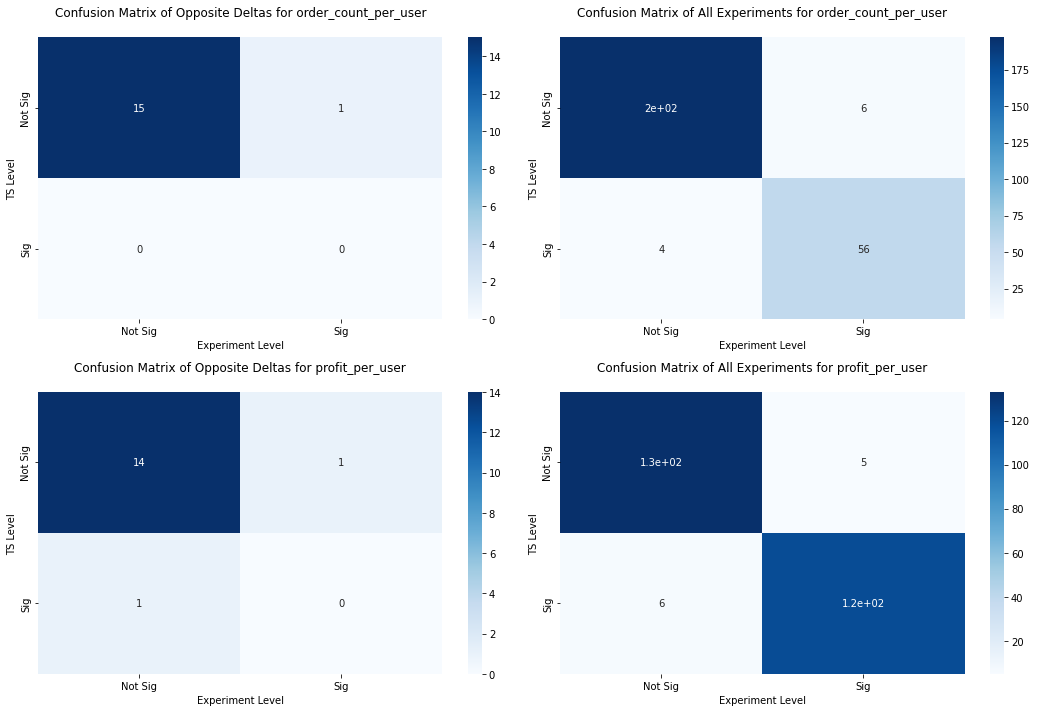

In [20]:
# Find the number of times the opposite direction deltas were statistically significant on BOTH the TS and experiment level granularities
def conf_matrix_func(df, kpi_prefix, data_cut):
    # Create the confusion matrix
    if data_cut == 'Opposite Deltas':
        df = df[df[kpi_prefix + '_delta_same_dir_flag'] == 'Delta - Opposite Direction'].reset_index(drop = True)
    elif data_cut == 'All Experiments':
        pass
    conf_matrix = confusion_matrix(df[kpi_prefix + '_per_user_sig_flag_ts'], df[kpi_prefix + '_per_user_sig_flag_exp'])

    # Visualize the confusion matrix via a heatmap
    ax = sns.heatmap(conf_matrix, annot = True, cmap = 'Blues')
    ax.set_title('Confusion Matrix of ' + data_cut + ' for ' + kpi_prefix + '_per_user\n')
    ax.set_xlabel('Experiment Level')
    ax.set_ylabel('TS Level')
    ax.xaxis.set_ticklabels(['Not Sig', 'Sig']) # Has to be in alphabetical order
    ax.yaxis.set_ticklabels(['Not Sig', 'Sig']) # Has to be in alphabetical order

# Plot the confusion matrices
plt.figure(figsize = (15,10))

plt.subplot(221)
conf_matrix_func(df = df_comp, kpi_prefix = 'order_count', data_cut = 'Opposite Deltas')
plt.subplot(222)
conf_matrix_func(df = df_comp, kpi_prefix = 'order_count', data_cut = 'All Experiments')
plt.subplot(223)
conf_matrix_func(df = df_comp, kpi_prefix = 'profit', data_cut = 'Opposite Deltas')
plt.subplot(224)
conf_matrix_func(df = df_comp, kpi_prefix = 'profit', data_cut = 'All Experiments')
plt.tight_layout()
plt.show()


### Q1': Why do we observe that the significance on the experiment and treatment scope levels usually point in the same direction (either both insignificant or both significant)

In [21]:
# For every test, calculate the number of distinct records in "df_raw_data_exp" per treatment_flag value ("Y", "N", "Unknown")
# One record corresponds to one "entity | test_name | variant | perseus_client_id | target_group | session_in_treatment_flag" combination
df_rec_per_tf = df_raw_data_exp.groupby(['entity_id', 'test_name', 'session_in_treatment_flag'])['perseus_client_id'].count().to_frame().reset_index().rename(columns = {'perseus_client_id': 'num_recs'})
df_rec_per_tf = df_rec_per_tf.pivot(index = ['entity_id', 'test_name'], columns = 'session_in_treatment_flag', values = 'num_recs')

# Get the percentage of combinations "in treatment"
df_rec_per_tf['perc_in_treatment'] = round(df_rec_per_tf['Y'] / (df_rec_per_tf['Y'] + df_rec_per_tf['N']), 4).fillna(1)

# Display the final data frame
display(df_rec_per_tf)

# Calculate summary statistics for the "perc_in_treatment" column
print(df_rec_per_tf['perc_in_treatment'].describe())

# Calculate the number of tests in different "perc_in_treatment" bins
df_rec_per_tf['perc_in_treatment_bins'] = pd.cut(df_rec_per_tf['perc_in_treatment'], bins = np.arange(0,1.05,0.05))
df_rec_per_tf['perc_in_treatment_bins'].value_counts().sort_index()

session_in_treatment_flag                                           N  \
entity_id test_name                                                     
FP_BD     Dmart Experiment (5 variations)                        19.0   
          Evergreen 2.0 Dmart Experiment (April-May)            328.0   
          Evergreen 2.1  Dmart Experiment (May-June)            111.0   
FP_HK     HK_20220404_R_EF_P_ SurgeMOVTinShuiWaiPost            422.0   
          HK_20220404_R_EF_P_SurgeMOVCentralPrePost            1920.0   
...                                                               ...   
TB_JO     JO_20221605_D_A0_R_tmart_Amman                      37176.0   
          JO_20221605_D_A0_R_tmart_Aqaba_Salt_Madaba             60.0   
          JO_20221605_D_A0_R_tmart_zarqa_irbid                12279.0   
TB_QA     (Slow Period) QA_20220525_R_B0_O_Price_Sensitivity    575.0   
          QA_20220525_R_B0_O_Price_Sensitivity                11305.0   

session_in_treatment_flag                                            Y  \
entity_id test_name                                                      
FP_BD     Dmart Experiment (5 variations)                      23400.0   
          Evergreen 2.0 Dmart Experiment (April-May)          170196.0   
          Evergreen 2.1  Dmart Experiment (May-June)           73126.0   
FP_HK     HK_20220404_R_EF_P_ SurgeMOVTinShuiWaiPost           26682.0   
          HK_20220404_R_EF_P_SurgeMOVCentralPrePost            38534.0   
...                                                                ...   
TB_JO     JO_20221605_D_A0_R_tmart_Amman                       77484.0   
          JO_20221605_D_A0_R_tmart_Aqaba_Salt_Madaba            8006.0   
          JO_20221605_D_A0_R_tmart_zarqa_irbid                 20194.0   
TB_QA     (Slow Period) QA_20220525_R_B0_O_Price_Sensitivity   39662.0   
          QA_20220525_R_B0_O_Price_Sensitivity                545620.0   

session_in_treatment_flag                                     perc_in_treatment  
entity_id test_name                                                              
FP_BD     Dmart Experiment (5 variations)                                0.9992  
          Evergreen 2.0 Dmart Experiment (April-May)                     0.9981  
          Evergreen 2.1  Dmart Experiment (May-June)                     0.9985  
FP_HK     HK_20220404_R_EF_P_ SurgeMOVTinShuiWaiPost                     0.9844  
          HK_20220404_R_EF_P_SurgeMOVCentralPrePost                      0.9525  
...                                                                         ...  
TB_JO     JO_20221605_D_A0_R_tmart_Amman                                 0.6758  
          JO_20221605_D_A0_R_tmart_Aqaba_Salt_Madaba                     0.9926  
          JO_20221605_D_A0_R_tmart_zarqa_irbid                           0.6219  
TB_QA     (Slow Period) QA_20220525_R_B0_O_Price_Sensitivity             0.9857  
          QA_20220525_R_B0_O_Price_Sensitivity                           0.9797  

[93 rows x 3 columns]

count    93.000000
mean      0.860019
std       0.207709
min       0.028000
25%       0.783800
50%       0.981500
75%       0.995100
max       1.000000
Name: perc_in_treatment, dtype: float64


(0.0, 0.05]     1
(0.05, 0.1]     0
(0.1, 0.15]     0
(0.15, 0.2]     0
(0.2, 0.25]     0
(0.25, 0.3]     1
(0.3, 0.35]     1
(0.35, 0.4]     1
(0.4, 0.45]     1
(0.45, 0.5]     1
(0.5, 0.55]     4
(0.55, 0.6]     2
(0.6, 0.65]     4
(0.65, 0.7]     6
(0.7, 0.75]     0
(0.75, 0.8]     4
(0.8, 0.85]     3
(0.85, 0.9]     2
(0.9, 0.95]     6
(0.95, 1.0]    56
Name: perc_in_treatment_bins, dtype: int64

In [22]:
# Do similar calculations, but for treatment orders instead of treatment sessions
x = df_analysis[df_analysis['granularity'] == 'exp'][['entity_id', 'test_name', 'perc_treatment_orders']].drop_duplicates().reset_index(drop = True) # A sneak-peak of the table
display(x)

# Summary statistics
print(x['perc_treatment_orders'].describe())

# Number of tests per perc_treatment_orders bin
x['perc_treatment_orders_bins'] = pd.cut(x['perc_treatment_orders'], bins = np.arange(0,1.05,0.05))
print(x['perc_treatment_orders_bins'].value_counts().sort_index())

,entity_id,test_name,perc_treatment_orders
0,FP_BD,Dmart Experiment (5 variations),1.0000
1,FP_BD,Evergreen 2.0 Dmart Experiment (April-May),1.0000
2,FP_BD,Evergreen 2.1 Dmart Experiment (May-June),1.0000
3,FP_HK,HK_20220404_R_EF_P_SurgeMOVCentralPrePost,0.9920
4,FP_HK,HK_20220404_R_EF_P_ SurgeMOVTinShuiWaiPost,0.9977
...,...,...,...
88,TB_JO,JO_20221605_D_A0_R_tmart_Aqaba_Salt_Madaba,1.0000
89,TB_JO,JO_20220523_R_B0_R_Salt,0.9576
90,TB_JO,JO_20220523_R_B0_R_Madaba,0.7393
91,TB_QA,QA_20220525_R_B0_O_Price_Sensitivity,0.9934


count    93.000000
mean      0.858348
std       0.228441
min       0.058800
25%       0.739300
50%       0.997200
75%       1.000000
max       1.000000
Name: perc_treatment_orders, dtype: float64
(0.0, 0.05]     0
(0.05, 0.1]     1
(0.1, 0.15]     1
(0.15, 0.2]     0
(0.2, 0.25]     0
(0.25, 0.3]     1
(0.3, 0.35]     2
(0.35, 0.4]     0
(0.4, 0.45]     1
(0.45, 0.5]     3
(0.5, 0.55]     5
(0.55, 0.6]     2
(0.6, 0.65]     2
(0.65, 0.7]     1
(0.7, 0.75]     7
(0.75, 0.8]     0
(0.8, 0.85]     3
(0.85, 0.9]     1
(0.9, 0.95]     3
(0.95, 1.0]    60
Name: perc_treatment_orders_bins, dtype: int64


### Q2: For different experiment lengths, how often do we get statistically insignificant results on the experiment level? This will help us evaluate whether it is worth it to include the non-TG vendors in the analysis at the expense of extending an experiment's runtime

In [23]:
def q2_func(df, test_length_bin_width, num_bins, kpi_prefix):
    # Create a list containing the test_length's bin thresholds
    bins = np.arange(0, test_length_bin_width*num_bins, 7).tolist()
    
    # Add a new column to df to cut the test_length column into bins
    df['test_length_binned'] = pd.cut(df['test_length'], bins = bins)
    
    # Calculate the number of times a variant was different from the control group in a statistically significant way
    y = df.groupby(['granularity', 'test_length_binned', kpi_prefix + '_sig_flag'])[kpi_prefix + '_p_val'].count().to_frame(name = 'freq')
    
    # Calculate the percentage of significant variants in every cross-section
    pct_sig = y.groupby(['granularity', 'test_length_binned']).freq.apply(lambda x: round(x[1] / x[0], 3)).to_frame()
    pct_sig = pct_sig.fillna(value = 0).rename(columns = {'freq': 'sig_pct'})

    # LEFT JOIN the "pct_sig" dataframe to "y"
    y = pd.merge(left = y.reset_index(), right = pct_sig.reset_index(), on = ['granularity', 'test_length_binned'], how = 'left')
    y = pd.pivot_table(y, index = ['test_length_binned'], columns = ['granularity', kpi_prefix + '_sig_flag'], aggfunc = sum)
    return y

display(q2_func(df = df_analysis, test_length_bin_width = 7, num_bins = 12, kpi_prefix = 'order_count_per_user'))
display(q2_func(df = df_analysis, test_length_bin_width = 7, num_bins = 12, kpi_prefix = 'profit_per_user'))

C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_1536\1143913850.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test_length_binned'] = pd.cut(df['test_length'], bins = bins)
C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_1536\1143913850.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  pct_sig = y.groupby(['granularity', 'test_length_binned']).freq.apply(lambda x: round(x[1] / x[0], 3)).to_frame()
C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_1536\1143913850.py:12: RuntimeWarning: divide by zero encountered in longlong_scalars
  pct_sig = y.groupby(['granularity', 'test_length_binned']).freq.apply(lambda x: round(x[1] / x[0], 3)).to_frame()


freq                 sig_pct                 \
granularity                       exp          ts         exp             ts   
order_count_per_user_sig_flag Not Sig Sig Not Sig Sig Not Sig    Sig Not Sig   
test_length_binned                                                             
(0, 7]                              0   0       0   0   0.000  0.000   0.000   
(7, 14]                            83  31      86  28   0.373  0.373   0.326   
(14, 21]                           30   4      29   5   0.133  0.133   0.172   
(21, 28]                           26   4      26   4   0.154  0.154   0.154   
(28, 35]                           20   8      20   8   0.400  0.400   0.400   
(35, 42]                            9   0       9   0   0.000  0.000   0.000   
(42, 49]                            9   5       9   5   0.556  0.556   0.556   
(49, 56]                           13   2      13   2   0.154  0.154   0.154   
(56, 63]                            0   1       0   1     inf    inf     inf   
(63, 70]                            9   7       9   7   0.778  0.778   0.778   
(70, 77]                            0   0       0   0   0.000  0.000   0.000   

                                      
granularity                           
order_count_per_user_sig_flag    Sig  
test_length_binned                    
(0, 7]                         0.000  
(7, 14]                        0.326  
(14, 21]                       0.172  
(21, 28]                       0.154  
(28, 35]                       0.400  
(35, 42]                       0.000  
(42, 49]                       0.556  
(49, 56]                       0.154  
(56, 63]                         inf  
(63, 70]                       0.778  
(70, 77]                       0.000

C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_1536\1143913850.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test_length_binned'] = pd.cut(df['test_length'], bins = bins)
C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_1536\1143913850.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  pct_sig = y.groupby(['granularity', 'test_length_binned']).freq.apply(lambda x: round(x[1] / x[0], 3)).to_frame()
C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_1536\1143913850.py:12: RuntimeWarning: divide by zero encountered in longlong_scalars
  pct_sig = y.groupby(['granularity', 'test_length_binned']).freq.apply(lambda x: round(x[1] / x[0], 3)).to_frame()


freq                 sig_pct                      
granularity                  exp          ts         exp             ts       
profit_per_user_sig_flag Not Sig Sig Not Sig Sig Not Sig    Sig Not Sig    Sig
test_length_binned                                                            
(0, 7]                         0   0       0   0   0.000  0.000   0.000  0.000
(7, 14]                       45  69      46  68   1.533  1.533   1.478  1.478
(14, 21]                      30   4      29   5   0.133  0.133   0.172  0.172
(21, 28]                      17  13      18  12   0.765  0.765   0.667  0.667
(28, 35]                      12  16      11  17   1.333  1.333   1.545  1.545
(35, 42]                       9   0       8   1   0.000  0.000   0.125  0.125
(42, 49]                      10   4      10   4   0.400  0.400   0.400  0.400
(49, 56]                       5  10       5  10   2.000  2.000   2.000  2.000
(56, 63]                       0   1       0   1     inf    inf     inf    inf
(63, 70]                      11   5      11   5   0.455  0.455   0.455  0.455
(70, 77]                       0   0       0   0   0.000  0.000   0.000  0.000

### Q3: How high does the percentage of treatment orders have to be to observe the effect of the treatment group when looking at the data on the experiment level?

In [24]:
# Create a new data frame to answer this question
df_q3 = df_analysis

# Cut the "perc_treatment_order" columns into bins according to the lower and upper bounds chosen in the inputs section
df_q3['perc_treatment_orders_binned'] = pd.cut(df_q3['perc_treatment_orders'], bins = [0, lower_bound_ts_order_pct, upper_bound_ts_order_pct, 1])

# Calculate the number of times a statistically significant delta was observed per bin (create a function and call it on order_count_per_user and profit_per_user)
# order_count_per_user
def sig_freq_per_ts_order_pct_func(df, kpi_prefix):
    df_freq = df.groupby(['granularity', 'perc_treatment_orders_binned', kpi_prefix + '_sig_flag'])['variant'].count().to_frame().rename(columns = {'variant': 'freq'})
    df_freq['prop'] = round(df_freq['freq']/df_freq.groupby(['granularity', 'perc_treatment_orders_binned']).freq.sum(), 4)
    return display(df_freq)

sig_freq_per_ts_order_pct_func(df_q3, 'order_count_per_user')
sig_freq_per_ts_order_pct_func(df_q3, 'profit_per_user')

C:\Users\Temporary Admin\AppData\Local\Temp\ipykernel_1536\2545904732.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q3['perc_treatment_orders_binned'] = pd.cut(df_q3['perc_treatment_orders'], bins = [0, lower_bound_ts_order_pct, upper_bound_ts_order_pct, 1])


freq  \
granularity perc_treatment_orders_binned order_count_per_user_sig_flag         
exp         (0.0, 0.2]                   Not Sig                           3   
                                         Sig                               0   
            (0.2, 0.5]                   Not Sig                          18   
                                         Sig                               3   
            (0.5, 1.0]                   Not Sig                         180   
                                         Sig                              59   
ts          (0.0, 0.2]                   Not Sig                           3   
                                         Sig                               0   
            (0.2, 0.5]                   Not Sig                          19   
                                         Sig                               2   
            (0.5, 1.0]                   Not Sig                         181   
                                         Sig                              58   

                                                                          prop  
granularity perc_treatment_orders_binned order_count_per_user_sig_flag          
exp         (0.0, 0.2]                   Not Sig                        1.0000  
                                         Sig                            0.0000  
            (0.2, 0.5]                   Not Sig                        0.8571  
                                         Sig                            0.1429  
            (0.5, 1.0]                   Not Sig                        0.7531  
                                         Sig                            0.2469  
ts          (0.0, 0.2]                   Not Sig                        1.0000  
                                         Sig                            0.0000  
            (0.2, 0.5]                   Not Sig                        0.9048  
                                         Sig                            0.0952  
            (0.5, 1.0]                   Not Sig                        0.7573  
                                         Sig                            0.2427

freq  \
granularity perc_treatment_orders_binned profit_per_user_sig_flag         
exp         (0.0, 0.2]                   Not Sig                      3   
                                         Sig                          0   
            (0.2, 0.5]                   Not Sig                     14   
                                         Sig                          7   
            (0.5, 1.0]                   Not Sig                    122   
                                         Sig                        117   
ts          (0.0, 0.2]                   Not Sig                      3   
                                         Sig                          0   
            (0.2, 0.5]                   Not Sig                     14   
                                         Sig                          7   
            (0.5, 1.0]                   Not Sig                    121   
                                         Sig                        118   

                                                                     prop  
granularity perc_treatment_orders_binned profit_per_user_sig_flag          
exp         (0.0, 0.2]                   Not Sig                   1.0000  
                                         Sig                       0.0000  
            (0.2, 0.5]                   Not Sig                   0.6667  
                                         Sig                       0.3333  
            (0.5, 1.0]                   Not Sig                   0.5105  
                                         Sig                       0.4895  
ts          (0.0, 0.2]                   Not Sig                   1.0000  
                                         Sig                       0.0000  
            (0.2, 0.5]                   Not Sig                   0.6667  
                                         Sig                       0.3333  
            (0.5, 1.0]                   Not Sig                   0.5063  
                                         Sig                       0.4937

In [25]:
%store x alpha_threshold df_analysis df_comp df_q3 df_raw_data_exp df_raw_data_ts df_rec_per_tf df_sig_combined df_sig_exp df_sig_ts df_ts_orders_pct lower_bound_ts_order_pct opp_dir_deltas_threshold sort_cols_1 sort_cols_2 sql_query_mab_dataset sql_query_ts_orders upper_bound_ts_order_pct

Stored 'alpha_threshold' (float)
Stored 'df_analysis' (DataFrame)
Stored 'df_comp' (DataFrame)
Stored 'df_q3' (DataFrame)
Stored 'df_raw_data_exp' (DataFrame)
Stored 'df_raw_data_ts' (DataFrame)
Stored 'df_rec_per_tf' (DataFrame)
Stored 'df_sig_combined' (DataFrame)
Stored 'df_sig_exp' (DataFrame)
Stored 'df_sig_ts' (DataFrame)
Stored 'df_ts_orders_pct' (DataFrame)
Stored 'lower_bound_ts_order_pct' (float)
Stored 'opp_dir_deltas_threshold' (float)
Stored 'sort_cols_1' (list)
Stored 'sort_cols_2' (list)
Stored 'sql_query_mab_dataset' (str)
Stored 'sql_query_ts_orders' (str)
Stored 'upper_bound_ts_order_pct' (float)
